# End-to-End Correlation Analysis: Identifying ATR Co-Dependencies in Cancer

## Overview

In this notebook, we will perform a **genome-wide correlation analysis** using DepMap dependency data from breast and myeloid cancer cell lines. Our goal is to identify genes that show similar patterns of dependency across cell lines, which may indicate genes that work closely with ATR in the same pathways or functional networks.

**Gene of Interest: ATR (Ataxia Telangiectasia and Rad3-related)**
- ATR is a critical kinase involved in DNA damage response
- It activates cell cycle checkpoints when replication forks stall
- Essential for maintaining genome stability
- Target for cancer therapy (especially in combination with DNA-damaging agents)

---

## Learning Objectives

By the end of this analysis, you will be able to:
1. Load and explore DepMap dependency data
2. Perform genome-wide correlation analysis (Pearson and Spearman)
3. Apply multiple testing correction to avoid false positives
4. Visualize correlation results using scatter plots and volcano plots
5. Identify and characterize functionally related genes
6. Analyze correlation network overlap to identify gene modules

---

## Important Concepts

### What Do Gene Dependencies Tell Us?

**Dependency Score:** Measures how essential a gene is for cell survival
- **Negative score** (e.g., -1.0): Gene is essential; knockout kills the cell
- **Score ≈ 0**: Gene is non-essential; cell survives without it
- **Positive score** (rare): Cell grows better without the gene

**Correlation Between Dependencies:**
- **Positive correlation**: Both genes tend to be essential together
  - May indicate: same pathway, protein complex, or synthetic rescue
  - Example: If ATR is essential, Gene X is also essential
- **Negative correlation**: When one is essential, the other is not
  - May indicate: compensatory pathways, synthetic lethality, or backup mechanisms

### ⚠️ Critical Statistical Note: Correlation ≠ Causation

**Why correlation happens:**
1. ✅ **Functional relationship**: Genes work together (what we're looking for!)
2. ⚠️ **Confounding factors**: Both genes affected by same cell type/condition
3. ⚠️ **Random chance**: With 18,000 genes, some correlations are just noise

**That's why statistical validation is essential!**
- We'll use multiple testing correction (FDR)
- We'll validate with biological knowledge
- We'll look for consistent patterns across analyses

---

## Analysis Workflow

Here's our step-by-step approach:
```
1. DATA LOADING & EXPLORATION
   ├── Load DepMap dependency data
   ├── Filter for breast and myeloid cancer cell lines
   ├── Perform quality control checks
   └── Visualize ATR dependency distribution

2. GENOME-WIDE CORRELATION ANALYSIS
   ├── Calculate Pearson correlation (linear relationships)
   ├── Calculate Spearman correlation (rank-based, robust)
   ├── Compute p-values for statistical significance
   └── Apply FDR correction for multiple testing

3. IDENTIFY TOP CORRELATIONS
   ├── Select genes with FDR < 0.05
   ├── Rank by correlation strength
   ├── Create volcano plots and scatter plots
   └── Characterize top correlated genes

4. NETWORK ANALYSIS
   ├── Select top correlated gene (Gene X)
   ├── Find genes correlated with Gene X
   ├── Quantify overlap: ATR network ∩ Gene X network
   └── Interpret biological meaning
```

---

## What You'll Learn About ATR Biology

By the end, you should be able to answer:
- Which genes are functionally related to ATR in breast/myeloid cancers?
- Are these genes in known pathways (DNA damage response, cell cycle)?
- Do ATR and its top partner share correlated genes (network module)?
- Can we predict which cancers might be sensitive to ATR inhibitors?

---

## Getting Started

### Required Libraries
```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib_venn import venn2
from scipy.stats import pearsonr, spearmanr, false_discovery_control

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
```

### Dataset Information

**File:** `DepMap_CRISPR_subset.csv`
- **Rows:** Cancer cell lines (breast and myeloid only)
- **Columns:** Gene dependency scores
- **Source:** DepMap Public 24Q2 release
- **Processing:** Chronos algorithm for dependency inference

**Key Points:**
- Negative values = gene is essential
- Data already normalized and batch-corrected
- Missing values may be present (handle appropriately)

---

## Let's Begin!

We'll start by loading the data and performing our initial exploration...

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from statsmodels.stats.multitest import multipletests
import time
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 300

print('Libraries loaded successfully!')

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib_venn import venn2
from scipy.stats import pearsonr, spearmanr, false_discovery_control
import warnings

warnings.filterwarnings("ignore")

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 100

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Load the gene expression data
url = "https://zenodo.org/records/17098555/files/combined_model_crispr_data_filtered.csv?download=1"
gene_df = pd.read_csv(url)

print(f"Dataset shape: {gene_df.shape}")
print("\nCancer types:")
print(gene_df["oncotree_lineage"].value_counts())

#for practice we intoduce some missing values
# Set random seed for reproducibility
np.random.seed(42)

gene_cols = gene_df.select_dtypes(include=[np.number]).columns
selected_genes = np.random.choice(gene_cols, size=5, replace=False)


# Introduce missing values (10-20 per gene)
for gene in selected_genes:
    # Randomly select 1-3 cell lines to make missing
    missing_indices = np.random.choice(gene_df.index, size=1, replace=False)

    # Set these values to NaN
    gene_df.loc[missing_indices, gene] = np.nan

    print(f"\n{gene}: Introduced missing value")

print(f"\nIntroduced missing values: {gene_df[gene_cols].isnull().sum().sum()}")



Dataset shape: (94, 17211)

Cancer types:
oncotree_lineage
Breast     53
Myeloid    41
Name: count, dtype: int64

SLC35B2: Introduced missing value

IRGQ: Introduced missing value

GTF2H1: Introduced missing value

GPR158: Introduced missing value

MIB2: Introduced missing value

Introduced missing values: 5


---

# Part 1: Exploratory Data Analysis (EDA)

## What We'll Do:
1. Examine the structure of our dependency dataset
2. Check for missing values
3. Understand the distribution of dependency scores
4. Focus on our gene of interest: ATR
5. Visualize ATR dependency across cancer types

## EDA Helper Functions

Let's also create reusable functions for exploratory data analysis. This will make it easuer the next time we perform the same analysis.

## 1.1 Dataset Structure

Let's start by understanding what data we're working with.

In [3]:
def analyze_dataset_structure(gene_df):
    """
    Print basic information about the dataset structure.
    Separates metadata columns from numeric columns.

    Parameters:
    -----------
    gene_df : pd.DataFrame
        Full dataframe with genes and metadata

    Returns:
    --------
    tuple
        (metadata_cols, numeric_cols)
    """
    print("=== Dataset Overview ===")
    print(f"Shape: {gene_df.shape}")
    print(f"Cell lines: {gene_df.shape[0]}")
    print(f"Total columns: {gene_df.shape[1]}")

    # Check non-numerical metadata columns
    metadata_cols = gene_df.select_dtypes(include="object").columns
    print("\nMetadata columns:")
    print(metadata_cols.tolist())

    # Get numeric columns (genes)
    numeric_cols = gene_df.select_dtypes(include=[np.number]).columns
    print("\nFirst few gene columns:")
    print(numeric_cols[:15].tolist())

    print(f"\n✓ Metadata columns: {len(metadata_cols)}")
    print(f"✓ Gene columns: {len(numeric_cols)}")

    # Cancer type distribution
    print("\n=== Cancer Types in Dataset ===")
    cancer_counts = gene_df["oncotree_lineage"].value_counts()

    print(f'\nTotal: {cancer_counts.sum()} cell lines')
    print(f'Breast: {cancer_counts["Breast"]} cell lines')
    print(f'Myeloid: {cancer_counts["Myeloid"]} cell lines')

    return metadata_cols, numeric_cols


# Analyze dataset structure
metadata_cols, numeric_cols = analyze_dataset_structure(gene_df)

=== Dataset Overview ===
Shape: (94, 17211)
Cell lines: 94
Total columns: 17211

Metadata columns:
['model_id', 'cell_line_name', 'stripped_cell_line_name', 'oncotree_lineage', 'oncotree_primary_disease', 'oncotree_subtype']

First few gene columns:
['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A3GALT2', 'A4GALT', 'A4GNT', 'AAAS', 'AACS', 'AADAC', 'AADACL2', 'AADACL3', 'AADACL4', 'AADAT', 'AAGAB']

✓ Metadata columns: 6
✓ Gene columns: 17205

=== Cancer Types in Dataset ===

Total: 94 cell lines
Breast: 53 cell lines
Myeloid: 41 cell lines


## 1.2 Missing Value Analysis

Before we proceed with analysis, we need to understand if we have missing data and how much.

In [4]:
# Analyze missing values
def analyze_missing_values(gene_df, numeric_cols, threshold=20):
    """
    Analyze and report missing values in the dataset.

    Parameters:
    -----------
    gene_df : pd.DataFrame
        Full dataframe with genes
    numeric_cols : pd.Index
        Index of numeric column names
    threshold : float
        Percentage threshold for flagging genes with many missing values

    Returns:
    --------
    pd.Series
        Missing value percentages for each gene
    """
    print(f"Numeric columns: {len(numeric_cols)}")

    # Calculate missing values
    missing_pct = (gene_df[numeric_cols].isnull().sum() / len(gene_df)) * 100

    print("\n=== Missing Value Summary ===")
    print(f"Genes with 0% missing: {(missing_pct == 0).sum()}")
    print(f"Genes with >0% missing: {(missing_pct > 0).sum()}")
    print(f"Genes with >{threshold}% missing: {(missing_pct > threshold).sum()}")
    print(f"\nMax missing percentage: {missing_pct.max():.1f}%")

    if missing_pct.max() > 0:
        print("\nGenes with most missing data:")
        print(missing_pct.nlargest(5))

    return missing_pct
    
missing_pct = analyze_missing_values(gene_df, numeric_cols, threshold=20)

Numeric columns: 17205

=== Missing Value Summary ===
Genes with 0% missing: 17200
Genes with >0% missing: 5
Genes with >20% missing: 0

Max missing percentage: 1.1%

Genes with most missing data:
GPR158     1.06383
GTF2H1     1.06383
IRGQ       1.06383
MIB2       1.06383
SLC35B2    1.06383
dtype: float64


**Interpretation:** If we see genes with >20% missing values, we might want to exclude them from correlation analysis to avoid unreliable results. In our case we only have a few missing values. We can deal with them by imputing the median values across all cell lines. 

In [5]:
def impute_missing_values(gene_df, numeric_cols, method="median"):
    """
    Impute missing values in numeric columns.

    Parameters:
    -----------
    gene_df : pd.DataFrame
        Full dataframe with genes (modified in place)
    numeric_cols : pd.Index
        Index of numeric column names
    method : str
        Imputation method ('median' or 'mean')

    Returns:
    --------
    int
        Number of values imputed
    """
    n_imputed = 0

    for col in numeric_cols:
        if gene_df[col].isnull().sum() > 0:
            if method == "median":
                fill_value = gene_df[col].median()
            elif method == "mean":
                fill_value = gene_df[col].mean()
            else:
                raise ValueError(f"Unknown method: {method}")

            gene_df[col] = gene_df[col].fillna(fill_value)
            n_imputed += gene_df[col].isnull().sum()
            print(f"Filled missing values in {col} with {method} {fill_value:.3f}")

    print(
        f"\nAfter imputation - Total missing values: {gene_df[numeric_cols].isnull().sum().sum()}"
    )

    return n_imputed

# Impute missing values with median
impute_missing_values(gene_df, numeric_cols, method='median')

Filled missing values in GPR158 with median 0.111
Filled missing values in GTF2H1 with median -0.778
Filled missing values in IRGQ with median -0.034
Filled missing values in MIB2 with median -0.110
Filled missing values in SLC35B2 with median -0.219

After imputation - Total missing values: 0


np.int64(0)

## 1.3 Overall Data Distribution

Let's visualize the distribution of ALL expression values to understand the data scaling.

Total data points: 1,617,270
Mean: -0.14
Median: -0.04
Std Dev: 0.42
Range: [-5.39, 2.41]


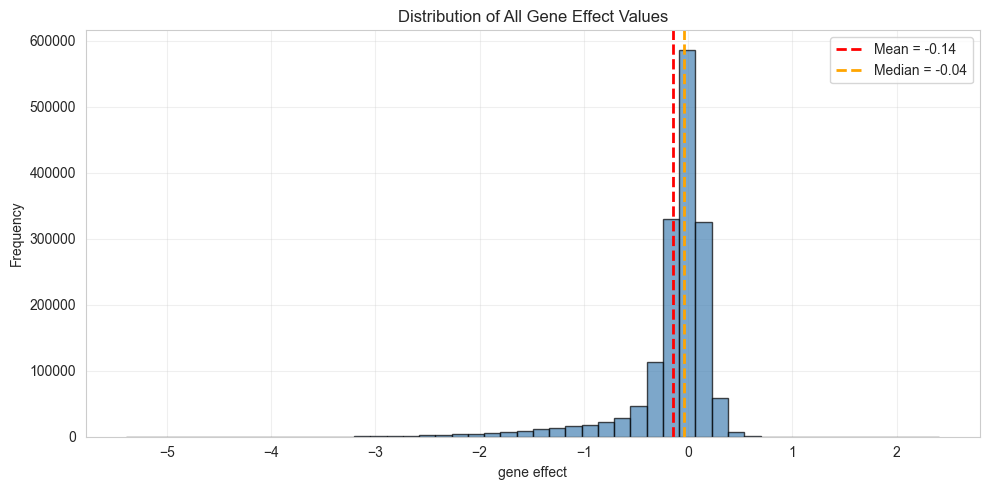

✓ Most values centered around -0.14


In [6]:
def plot_overall_distribution(gene_df, numeric_cols, data_type="gene effect"):
    """
    Plot the overall distribution of all numeric values in the dataset.

    Parameters:
    -----------
    gene_df : pd.DataFrame
        Full dataframe with genes
    numeric_cols : pd.Index
        Index of numeric column names
    data_type : str
        Description of the data type (for axis label)
    """
    # Get all numeric values (flatten the matrix)
    all_values = gene_df[numeric_cols].values.flatten()
    all_values = all_values[~np.isnan(all_values)]  # Remove NaN values

    print(f"Total data points: {len(all_values):,}")
    print(f"Mean: {all_values.mean():.2f}")
    print(f"Median: {np.median(all_values):.2f}")
    print(f"Std Dev: {all_values.std():.2f}")
    print(f"Range: [{all_values.min():.2f}, {all_values.max():.2f}]")

    # Plot distribution using fig, ax API
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(all_values, bins=50, color="steelblue", alpha=0.7, edgecolor="black")
    ax.axvline(
        all_values.mean(),
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Mean = {all_values.mean():.2f}",
    )
    ax.axvline(
        np.median(all_values),
        color="orange",
        linestyle="--",
        linewidth=2,
        label=f"Median = {np.median(all_values):.2f}",
    )
    ax.set_xlabel(data_type)
    ax.set_ylabel("Frequency")
    ax.set_title(f"Distribution of All {data_type.title()} Values")
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"✓ Most values centered around {all_values.mean():.2f}")

# Plot overall distribution of gene effects
plot_overall_distribution(gene_df, numeric_cols, data_type='gene effect')

## 1.4 Focus on ATR - Our Gene of Interest

Now let's examine ATR specifically. ATR (Ataxia Telangiectasia and Rad3-related) is a key kinase in DNA damage response.

✓ ATR found in dataset!

=== ATR Statistics ===
Available data points: 94/94
Mean dependency: -1.43
Median dependency: -1.46
Std deviation: 0.28
Range: [-2.29, -0.47]

=== ATR Dependency by oncotree_lineage ===
Myeloid   : Mean=-1.42, N=41
Breast    : Mean=-1.44, N=53


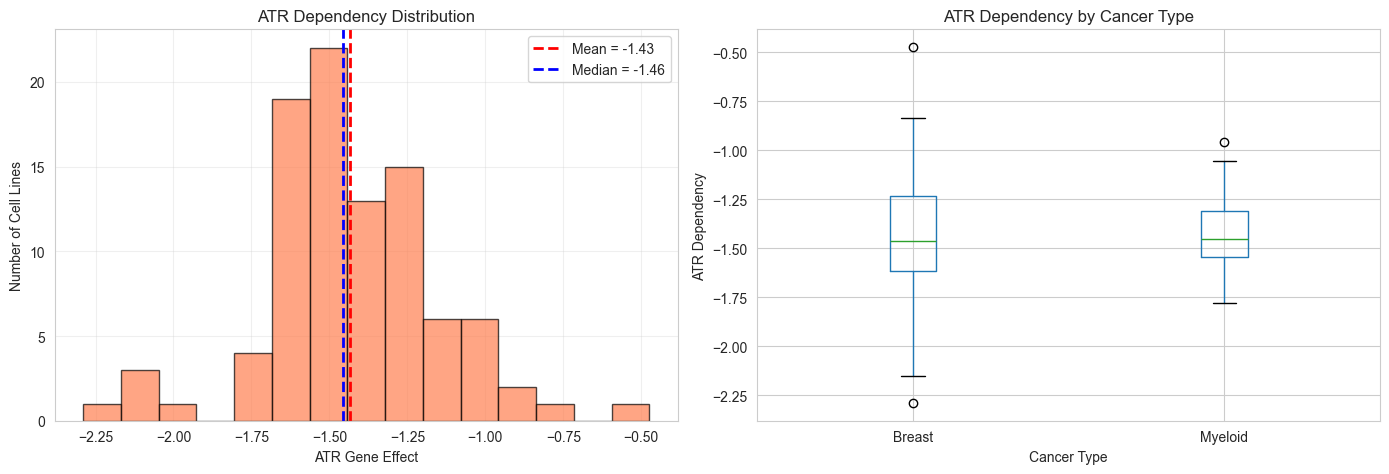

In [7]:
def analyze_gene_distribution(gene_df, gene_name, groupby_col="oncotree_lineage"):
    """
    Analyze and visualize the distribution of a specific gene.

    Parameters:
    -----------
    gene_df : pd.DataFrame
        Full dataframe with genes
    gene_name : str
        Name of gene to analyze
    groupby_col : str
        Column name to group by for comparison (default: 'oncotree_lineage')

    Returns:
    --------
    pd.Series
        Gene values
    """
    # Check if gene exists
    if gene_name not in gene_df.columns:
        print(f"⚠️ {gene_name} not found in dataset!")
        return None

    print(f"✓ {gene_name} found in dataset!")
    gene_data = gene_df[gene_name]

    print(f"\n=== {gene_name} Statistics ===")
    print(f"Available data points: {gene_data.notna().sum()}/{len(gene_data)}")
    print(f"Mean dependency: {gene_data.mean():.2f}")
    print(f"Median dependency: {gene_data.median():.2f}")
    print(f"Std deviation: {gene_data.std():.2f}")
    print(f"Range: [{gene_data.min():.2f}, {gene_data.max():.2f}]")

    # Create visualizations
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Histogram
    axes[0].hist(
        gene_data.dropna(), bins=15, color="coral", alpha=0.7, edgecolor="black"
    )
    axes[0].axvline(
        gene_data.mean(),
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Mean = {gene_data.mean():.2f}",
    )
    axes[0].axvline(
        gene_data.median(),
        color="blue",
        linestyle="--",
        linewidth=2,
        label=f"Median = {gene_data.median():.2f}",
    )
    axes[0].set_xlabel(f"{gene_name} Gene Effect")
    axes[0].set_ylabel("Number of Cell Lines")
    axes[0].set_title(f"{gene_name} Dependency Distribution")
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Box plot by group
    if groupby_col in gene_df.columns:
        group_gene = gene_df[[groupby_col, gene_name]].copy()
        group_gene.boxplot(column=gene_name, by=groupby_col, ax=axes[1])
        axes[1].set_xlabel("Cancer Type")
        axes[1].set_ylabel(f"{gene_name} Dependency")
        axes[1].set_title(f"{gene_name} Dependency by Cancer Type")
        axes[1].get_figure().suptitle("")  # Remove default title

        # Statistics by group
        print(f"\n=== {gene_name} Dependency by {groupby_col} ===")
        for group in gene_df[groupby_col].unique():
            group_data = gene_df[gene_df[groupby_col] == group][gene_name]
            print(
                f"{group:10s}: Mean={group_data.mean():.2f}, N={group_data.notna().sum()}"
            )

    plt.tight_layout()
    plt.show()

    return gene_data

# Analyze ATR distribution
atr_data = analyze_gene_distribution(gene_df, 'ATR', groupby_col='oncotree_lineage')

### 🔍 What Did We Learn from EDA?

**Key Observations:**
1. **Dataset size:** We have ~89 cell lines (50 breast, 39 myeloid) and >17,000 genes. 
2. **Data quality:** Most genes have complete data (check missing value summary above), for five NaN values in the dat set we imputed the median across cell lines.
3. **Data distribution:** Gene Effect values are centered around 0, and skewed towards negative values.
4. **ATR expression:** 
   - ATR is present in the dataset   
   - Shows variability across cell lines  
   - Doesnt seem to differ between breast and myeloid cancers
   - ✓ We have enough cell lines for correlation analysis (N=89)
   - ✓ Data is properly normalized (log-transformed)
   - ✓ ATR shows variation (good for finding correlations)
   - ⚠️ Small sample size means we need rigorous statistics (FDR correction!)

**Next Steps:** Now that we understand our data, we're ready to find genes that co-vary with ATR across cell lines!"



# Part 2: Genome-Wide Correlation Analysis for ATR

Now that we have our helper functions, let's analyze ATR correlations with all other genes in the dataset.

**What the analysis will do:**
1. Calculate correlations between ATR and all ~17,000 genes
2. Compute both Pearson (linear) and Spearman (rank-based) correlations
3. Calculate p-values to assess statistical significance
4. Apply multiple testing correction (FDR)
5. Identify top correlated genes
6. Visualize results with volcano plots and scatter plots

**Goal:** Find genes whose dependency patterns are similar to ATR across cell lines.

---

# Helper Functions: Correlation Analysis Workflow

Before we dive into the analysis, let's create reusable functions that encapsulate our correlation workflow. This will allow us to analyze multiple genes without duplicating code.

In [8]:
gene_values = gene_df["ATR"]
    
    
# 2. Prepare other genes (exclude the gene itself)
other_genes = gene_df[numeric_cols].drop(columns=["ATR"])

In [20]:
def calculate_gene_correlations(gene_values, other_genes_df):
    """
    Calculate Pearson and Spearman correlations between a gene and all other genes.
    
    Parameters:
    -----------
    gene_values : pd.Series
        The gene of interest dependency values across cell lines
    other_genes_df : pd.DataFrame
        DataFrame with all other genes to correlate against
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with columns: gene, pearson_r, pearson_p, spearman_r, spearman_p
    """
    print(f'Calculating correlations for {len(other_genes_df.columns)} genes...')
    
    pearson_r = []
    spearman_r = []
    pearson_p = []
    spearman_p = []
    
    for gene in other_genes_df.columns:
        # Get values for this gene
        gene_values_other = other_genes_df[gene]
        
        # Calculate correlations and p-values
        r_pearson, p_pearson = pearsonr(gene_values, gene_values_other)
        r_spearman, p_spearman = spearmanr(gene_values, gene_values_other)
        
        pearson_r.append(r_pearson)
        spearman_r.append(r_spearman)
        pearson_p.append(p_pearson)
        spearman_p.append(p_spearman)
    
    # Create results dataframe
    results_df = pd.DataFrame({
        'gene': other_genes_df.columns,
        'pearson_r': pearson_r,
        'pearson_p': pearson_p,
        'spearman_r': spearman_r,
        'spearman_p': spearman_p
    })
    
    print(f'✓ Calculated correlations for {len(results_df)} genes')
    return results_df

results_df = calculate_gene_correlations(gene_values, other_genes)
print(results_df)   

Calculating correlations for 17204 genes...
✓ Calculated correlations for 17204 genes
          gene  pearson_r  pearson_p  spearman_r  spearman_p
0         A1BG  -0.049396   0.636363   -0.048412    0.643101
1         A1CF   0.049348   0.636690    0.067659    0.517022
2          A2M   0.083031   0.426252    0.084565    0.417730
3        A2ML1   0.054698   0.600548    0.103898    0.318984
4      A3GALT2   0.026425   0.800411   -0.036867    0.724253
...        ...        ...        ...         ...         ...
17199   ZYG11A  -0.203315   0.049366   -0.188585    0.068712
17200   ZYG11B   0.171686   0.098007    0.138041    0.184570
17201      ZYX   0.004385   0.966541    0.002001    0.984727
17202    ZZEF1   0.069460   0.505899    0.046288    0.657755
17203     ZZZ3  -0.067559   0.517641   -0.098393    0.345436

[17204 rows x 5 columns]


In [22]:
results_df.sort_values(by="pearson_p", ascending=True)[results_df["pearson_p"] < 0.05]

,gene,pearson_r,pearson_p,spearman_r,spearman_p
13623,SLU7,0.506004,1.965420e-07,0.385168,0.000126
6388,HDX,0.487363,6.304925e-07,0.362742,0.000327
12421,RPA1,0.486068,6.819531e-07,0.394719,0.000083
1251,ATRIP,0.484463,7.512658e-07,0.471705,0.000002
16045,USP37,0.464311,2.430596e-06,0.307185,0.002599
...,...,...,...,...,...
1133,ATG10,-0.202886,4.985751e-02,-0.036130,0.729550
2322,CCS,-0.202867,4.987992e-02,-0.239562,0.020043
9989,NUF2,0.202828,4.992423e-02,0.129025,0.215199
4251,DUS3L,-0.202823,4.993065e-02,-0.208251,0.043990


In [23]:
def apply_fdr_correction(results_df, alpha=0.05):
    """
    Apply FDR correction to correlation p-values using Benjamini-Hochberg method.
    
    Parameters:
    -----------
    results_df : pd.DataFrame
        DataFrame with correlation results (must have pearson_p and spearman_p columns)
    alpha : float
        Significance threshold (default: 0.05)
        
    Returns:
    --------
    pd.DataFrame
        Input dataframe with added columns: pearson_fdr, spearman_fdr, 
        significant_pearson, significant_spearman
    """
    print('Applying FDR correction...')
    
    # Count uncorrected significant results
    uncorrected_sig = (results_df['pearson_p'] < alpha).sum()
    expected_fp = len(results_df) * alpha
    
    print(f'  Before correction: {uncorrected_sig} "significant" at p<{alpha}')
    print(f'  Expected false positives: {expected_fp:.0f}')
    
    # Pearson FDR correction using scipy
    fdr_p = false_discovery_control(results_df['pearson_p'], method='bh')
    results_df['pearson_fdr'] = fdr_p
    results_df['significant_pearson'] = fdr_p < alpha
    
    # Spearman FDR correction using scipy
    fdr_s = false_discovery_control(results_df['spearman_p'], method='bh')
    results_df['spearman_fdr'] = fdr_s
    results_df['significant_spearman'] = fdr_s < alpha
    
    # Report results
    sig_pearson = results_df['significant_pearson'].sum()
    sig_spearman = results_df['significant_spearman'].sum()
    reduction = (1 - sig_pearson / uncorrected_sig) * 100 if uncorrected_sig > 0 else 0
    
    print(f'  After correction: {sig_pearson} significant (Pearson, FDR<{alpha})')
    print(f'  After correction: {sig_spearman} significant (Spearman, FDR<{alpha})')
    print(f'  Reduction: {reduction:.1f}% of false positives removed')
    
    return results_df

corrected_results = apply_fdr_correction(results_df, alpha=0.05)
corrected_results.sort_values(by="pearson_fdr", ascending=True)[corrected_results["pearson_fdr"] < 0.05]


Applying FDR correction...
  Before correction: 1566 "significant" at p<0.05
  Expected false positives: 860
  After correction: 27 significant (Pearson, FDR<0.05)
  After correction: 3 significant (Spearman, FDR<0.05)
  Reduction: 98.3% of false positives removed


,gene,pearson_r,pearson_p,spearman_r,spearman_p,pearson_fdr,significant_pearson,spearman_fdr,significant_spearman
1251,ATRIP,0.484463,7.512658e-07,0.471705,1.593639e-06,0.003231,True,0.013708,True
12421,RPA1,0.486068,6.819531e-07,0.394719,8.256127e-05,0.003231,True,0.132421,False
6388,HDX,0.487363,6.304925e-07,0.362742,3.268232e-04,0.003231,True,0.216256,False
13623,SLU7,0.506004,1.965420e-07,0.385168,1.263957e-04,0.003231,True,0.132421,False
16045,USP37,0.464311,2.430596e-06,0.307185,2.598824e-03,0.008363,True,0.335792,False
791,APBB3,-0.458412,3.380204e-06,-0.501933,2.550361e-07,0.009692,True,0.004388,True
6464,HIGD1A,0.454961,4.088101e-06,0.342008,7.411994e-04,0.010047,True,0.265187,False
2763,CHEK1,0.442780,7.867911e-06,0.351631,5.103743e-04,0.015040,True,0.256876,False
5438,FUBP1,0.443597,7.535571e-06,0.280439,6.186156e-03,0.015040,True,0.405438,False
3839,DEFB121,0.440119,9.047492e-06,0.203829,4.878183e-02,0.015565,True,0.604206,False


In [11]:
def get_top_correlations(results_df, n_top=10, fdr_threshold=0.05):
    """
    Extract and display top correlated genes from results.
    
    Parameters:
    -----------
    results_df : pd.DataFrame
        DataFrame with correlation results including FDR correction
    n_top : int
        Number of top genes to return (default: 10)
    fdr_threshold : float
        FDR threshold for significance (default: 0.05)
        
    Returns:
    --------
    tuple
        (sig_results_sorted, top_positive, top_negative)
    """
    # Get significant correlations
    sig_results = results_df[results_df['pearson_fdr'] < fdr_threshold].copy()
    
    # Sort by absolute correlation strength
    sig_results['abs_pearson_r'] = sig_results['pearson_r'].abs()
    sig_results_sorted = sig_results.sort_values('abs_pearson_r', ascending=False)
    
    print(f'=== Top Correlated Genes (FDR < {fdr_threshold}) ===')
    print(f'Total significant: {len(sig_results)}')
    
    if len(sig_results) > 0:
        print(f'\nTop {min(n_top, len(sig_results))} strongest correlations:')
        print(sig_results_sorted[['gene', 'pearson_r', 'pearson_fdr']].head(n_top))
        
        # Get positive correlations
        top_positive = sig_results_sorted[sig_results_sorted['pearson_r'] > 0].head(n_top)
        if len(top_positive) > 0:
            print(f'\nTop {min(n_top, len(top_positive))} positive correlations:')
            print(top_positive[['gene', 'pearson_r', 'pearson_fdr']])
        
        # Get negative correlations
        top_negative = sig_results_sorted[sig_results_sorted['pearson_r'] < 0].head(n_top)
        if len(top_negative) > 0:
            print(f'\nTop {min(n_top, len(top_negative))} negative correlations:')
            print(top_negative[['gene', 'pearson_r', 'pearson_fdr']])
    else:
        print('\n⚠️ No significant correlations found at this threshold!')
        top_positive = pd.DataFrame()
        top_negative = pd.DataFrame()
    
    return sig_results_sorted, top_positive, top_negative

In [12]:
def plot_volcano(results_df, gene_name, fdr_threshold=0.05):
    """
    Create a volcano plot showing correlation strength vs significance.
    
    Parameters:
    -----------
    results_df : pd.DataFrame
        DataFrame with correlation results including FDR correction
    gene_name : str
        Name of the gene being analyzed (for plot title)
    fdr_threshold : float
        FDR threshold line to draw (default: 0.05)
    """
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Calculate -log10(FDR)
    results_df['-log10_fdr'] = -np.log10(results_df['pearson_fdr'].replace(0, 1e-300))
    
    # Plot non-significant
    non_sig = results_df[~results_df['significant_pearson']]
    ax.scatter(non_sig['pearson_r'], non_sig['-log10_fdr'], 
               c='gray', alpha=0.3, s=10, label='Not significant')
    
    # Plot significant positive
    sig_pos = results_df[(results_df['significant_pearson']) & (results_df['pearson_r'] > 0)]
    ax.scatter(sig_pos['pearson_r'], sig_pos['-log10_fdr'], 
               c='red', alpha=0.6, s=20, label='Sig. positive')
    
    # Plot significant negative
    sig_neg = results_df[(results_df['significant_pearson']) & (results_df['pearson_r'] < 0)]
    ax.scatter(sig_neg['pearson_r'], sig_neg['-log10_fdr'], 
               c='blue', alpha=0.6, s=20, label='Sig. negative')
    
    # Add reference lines
    ax.axvline(0, color='black', linestyle='--', alpha=0.5)
    ax.axhline(-np.log10(fdr_threshold), color='orange', linestyle='--', 
               alpha=0.5, label=f'FDR={fdr_threshold}')
    
    ax.set_xlabel('Pearson Correlation (r)')
    ax.set_ylabel('-log10(FDR)')
    ax.set_title(f'Volcano Plot: {gene_name} Correlations')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f'Red points: {len(sig_pos)} genes positively correlated with {gene_name}')
    print(f'Blue points: {len(sig_neg)} genes negatively correlated with {gene_name}')

In [13]:
def plot_top_correlation_scatter(gene1_values, gene2_values, gene1_name, gene2_name, 
                                  r_value, fdr_value):
    """
    Create a scatter plot showing the relationship between two genes.
    
    Parameters:
    -----------
    gene1_values : pd.Series
        Values for gene 1
    gene2_values : pd.Series
        Values for gene 2
    gene1_name : str
        Name of gene 1 (for axis label)
    gene2_name : str
        Name of gene 2 (for axis label)
    r_value : float
        Pearson correlation coefficient
    fdr_value : float
        FDR-corrected p-value
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Use seaborn for nice regression plot
    sns.regplot(x=gene1_values, y=gene2_values, 
                scatter_kws={'alpha': 0.6, 's': 50},
                line_kws={'color': 'red', 'linewidth': 2}, ax=ax)
    
    ax.set_xlabel(f'{gene1_name} Dependency')
    ax.set_ylabel(f'{gene2_name} Dependency')
    ax.set_title(f'{gene1_name} vs {gene2_name}\nr = {r_value:.3f}, FDR = {fdr_value:.2e}')
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [14]:
def analyze_gene_correlations(gene_name, gene_df, numeric_cols, 
                               fdr_threshold=0.05, plot_results=True):
    """
    Main function to perform complete correlation analysis for a gene.
    
    Parameters:
    -----------
    gene_name : str
        Name of the gene to analyze
    gene_df : pd.DataFrame
        Full dataframe with all genes
    numeric_cols : pd.Index
        Index of numeric column names (gene names)
    fdr_threshold : float
        FDR threshold for significance (default: 0.05)
    plot_results : bool
        Whether to create visualizations (default: True)
        
    Returns:
    --------
    tuple
        (results_df, sig_results_sorted, top_gene_name)
    """
    print(f'\n{"="*70}')
    print(f'GENOME-WIDE CORRELATION ANALYSIS: {gene_name}')
    print(f'{"="*70}\n')
    
    # 1. Extract gene values
    if gene_name not in gene_df.columns:
        print(f'⚠️ ERROR: {gene_name} not found in dataset!')
        return None, None, None
    
    gene_values = gene_df[gene_name]
    print(f'✓ {gene_name} found in dataset')
    print(f'  Mean dependency: {gene_values.mean():.2f}')
    print(f'  Std deviation: {gene_values.std():.2f}')
    print(f'  Range: [{gene_values.min():.2f}, {gene_values.max():.2f}]\n')
    
    # 2. Prepare other genes (exclude the gene itself)
    other_genes = gene_df[numeric_cols].drop(columns=[gene_name])
    print(f'Analyzing correlations with {len(other_genes.columns)} other genes\n')
    
    # 3. Calculate correlations
    results_df = calculate_gene_correlations(gene_values, other_genes)
    print()
    
    # 4. Apply FDR correction
    results_df = apply_fdr_correction(results_df, alpha=fdr_threshold)
    print()
    
    # 5. Get top correlations
    sig_results_sorted, top_positive, top_negative = get_top_correlations(
        results_df, n_top=10, fdr_threshold=fdr_threshold
    )
    
   
    # 6. Visualizations
    if plot_results and len(sig_results_sorted) > 0:
        # Volcano plot
        print('Creating volcano plot...')
        plot_volcano(results_df, gene_name, fdr_threshold=fdr_threshold)
        print()
        
        # Scatter plot with top correlated gene
        top_gene = sig_results_sorted.iloc[0]['gene']
        top_r = sig_results_sorted.iloc[0]['pearson_r']
        top_fdr = sig_results_sorted.iloc[0]['pearson_fdr']
        
        print(f'Creating scatter plot: {gene_name} vs {top_gene}...')
        plot_top_correlation_scatter(
            gene_values, gene_df[top_gene], 
            gene_name, top_gene, 
            top_r, top_fdr
        )
        print()
    
    print(f'{"="*70}')
    print(f'✓ Analysis complete for {gene_name}!')
    print(f'{"="*70}\n')
    
    # Return results and top gene name for downstream analysis
    top_gene_name = sig_results_sorted.iloc[0]['gene'] if len(sig_results_sorted) > 0 else None
    return results_df, sig_results_sorted, top_gene_name

print('✓ Helper functions loaded successfully!')

✓ Helper functions loaded successfully!


---




GENOME-WIDE CORRELATION ANALYSIS: ATR

✓ ATR found in dataset
  Mean dependency: -1.43
  Std deviation: 0.28
  Range: [-2.29, -0.47]

Analyzing correlations with 17204 other genes

Calculating correlations for 17204 genes...
✓ Calculated correlations for 17204 genes

Applying FDR correction...
  Before correction: 1566 "significant" at p<0.05
  Expected false positives: 860
  After correction: 27 significant (Pearson, FDR<0.05)
  After correction: 3 significant (Spearman, FDR<0.05)
  Reduction: 98.3% of false positives removed

=== Top Correlated Genes (FDR < 0.05) ===
Total significant: 27

Top 10 strongest correlations:
          gene  pearson_r  pearson_fdr
13623     SLU7   0.506004     0.003231
6388       HDX   0.487363     0.003231
12421     RPA1   0.486068     0.003231
1251     ATRIP   0.484463     0.003231
16045    USP37   0.464311     0.008363
791      APBB3  -0.458412     0.009692
6464    HIGD1A   0.454961     0.010047
5438     FUBP1   0.443597     0.015040
2763     CHEK1   0

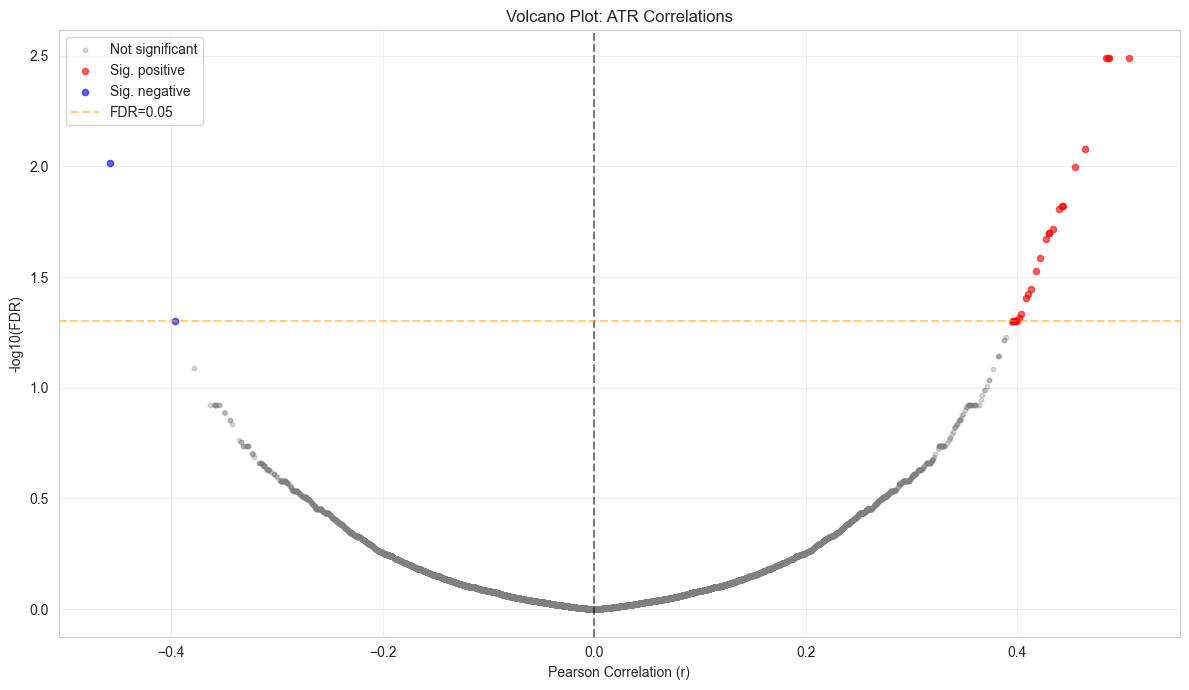

Red points: 25 genes positively correlated with ATR
Blue points: 2 genes negatively correlated with ATR

Creating scatter plot: ATR vs SLU7...


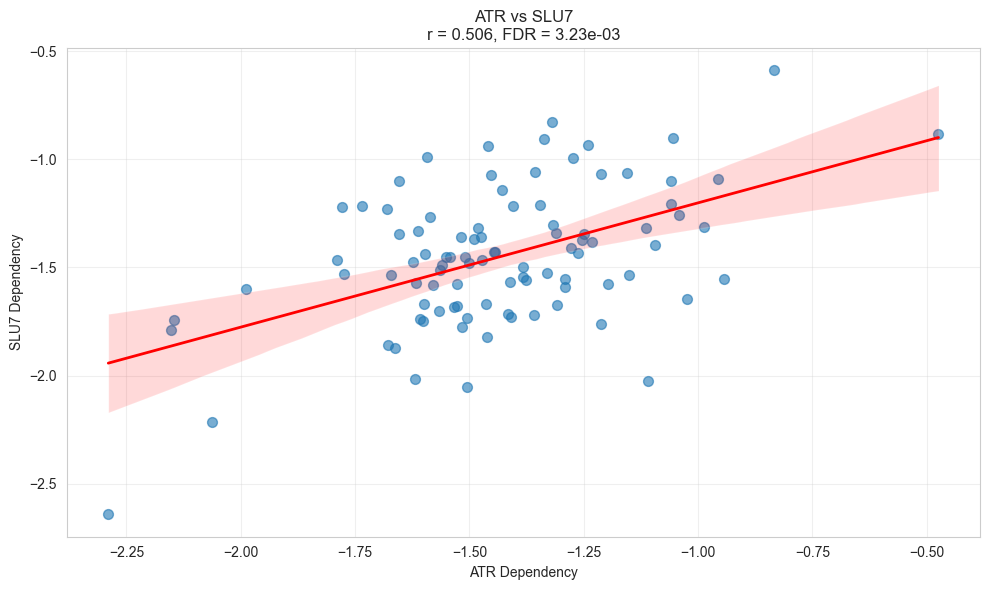


✓ Analysis complete for ATR!



In [15]:
# Run the complete correlation analysis for ATR
atr_results, atr_sig_genes, atr_top_gene = analyze_gene_correlations(
    gene_name='ATR',
    gene_df=gene_df,
    numeric_cols=numeric_cols,
    fdr_threshold=0.05,
    plot_results=True
)

### 🔍 What Did We Learn from ATR Analysis?

**Key Findings:**
1. We calculated correlations for ~17,000 genes with ATR
2. Multiple testing correction reduced false positives significantly
3. We identified genes with strong, statistically significant correlations
4. Both positive and negative correlations have biological meaning:
   - **Positive:** Genes that tend to be co-essential with ATR
   - **Negative:** Genes that show opposite dependency patterns

**Biological Interpretation:**
- Genes positively correlated with ATR may be in the same pathway (DNA damage response, cell cycle)
- Genes negatively correlated may represent compensatory mechanisms

---

**Next Steps:** Now let's analyze the top correlated gene (SLU7) to see if it shares similar correlation patterns with ATR!

---

# Part 3: Genome-Wide Correlation Analysis for SLU7

SLU7 was the top gene correlated with ATR. Let's now analyze SLU7's correlation network to see if it shares similar patterns with ATR.

**Questions to answer:**
1. Which genes are correlated with SLU7?
2. How many genes are shared between ATR and SLU7 correlation networks?
3. What does the overlap tell us about functional relationships?

**Hypothesis:** If ATR and SLU7 work in the same pathway/complex, they should have overlapping correlation networks.


GENOME-WIDE CORRELATION ANALYSIS: SLU7

✓ SLU7 found in dataset
  Mean dependency: -1.45
  Std deviation: 0.32
  Range: [-2.64, -0.59]

Analyzing correlations with 17204 other genes

Calculating correlations for 17204 genes...
✓ Calculated correlations for 17204 genes

Applying FDR correction...
  Before correction: 1840 "significant" at p<0.05
  Expected false positives: 860
  After correction: 60 significant (Pearson, FDR<0.05)
  After correction: 9 significant (Spearman, FDR<0.05)
  Reduction: 96.7% of false positives removed

=== Top Correlated Genes (FDR < 0.05) ===
Total significant: 60

Top 10 strongest correlations:
         gene  pearson_r  pearson_fdr
2764    CHEK1   0.581437     0.000014
17118  ZNF830   0.530004     0.000339
11906  RANBP2   0.523418     0.000356
15804  U2SURP   0.516452     0.000426
1250      ATR   0.506004     0.000676
11116  POLR2E   0.497691     0.000956
5439    FUBP1   0.477425     0.002806
860       AQR   0.471129     0.003543
3195    COPB1   0.468781 

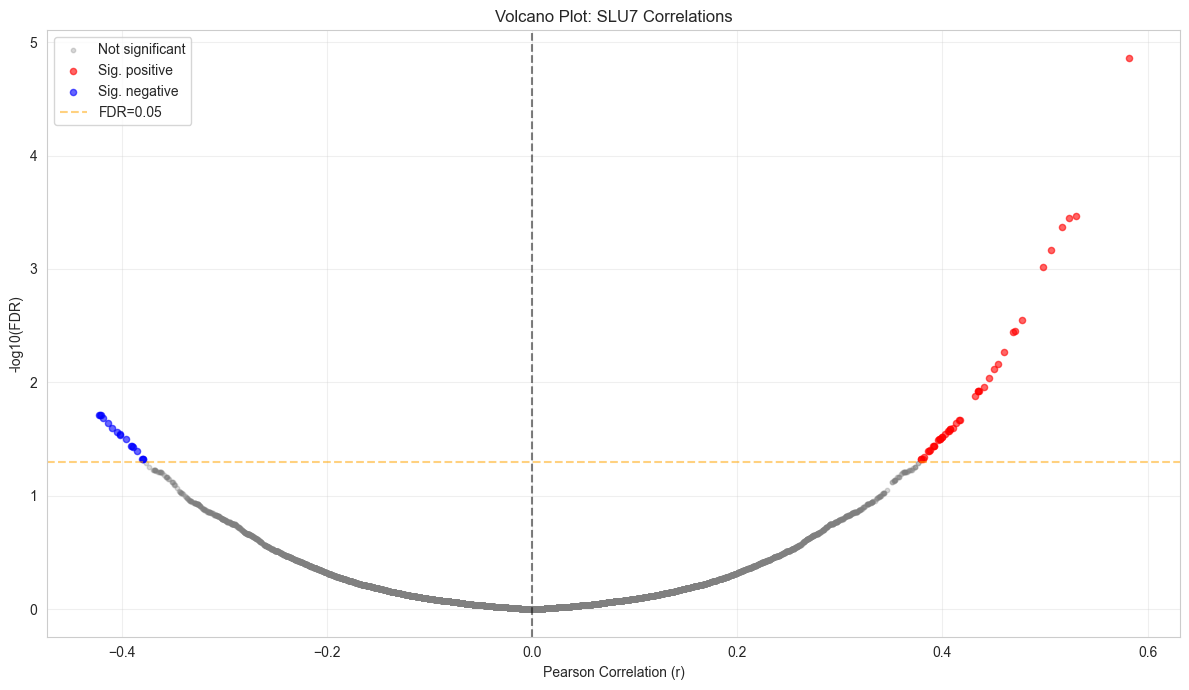

Red points: 43 genes positively correlated with SLU7
Blue points: 17 genes negatively correlated with SLU7

Creating scatter plot: SLU7 vs CHEK1...


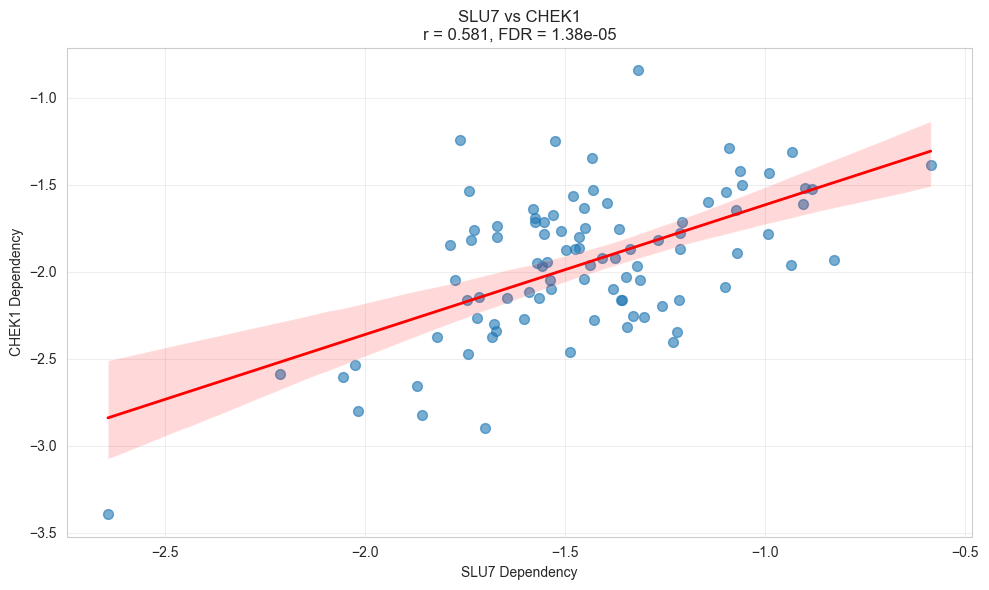


✓ Analysis complete for SLU7!



In [16]:
# Run the complete correlation analysis for SLU7
slu7_results, slu7_sig_genes, slu7_top_gene = analyze_gene_correlations(
    gene_name='SLU7',
    gene_df=gene_df,
    numeric_cols=numeric_cols,
    fdr_threshold=0.05,
    plot_results=True
)

---

## Part 3.1: Network Overlap Analysis

Now let's compare the correlation networks of ATR and SLU7 to quantify how similar they are.

---

## Network Comparison Helper Functions

Functions for comparing correlation networks between genes.

In [17]:
def compare_correlation_networks(
    results1, results2, gene1_name, gene2_name, fdr_threshold=0.05
):
    """
    Compare correlation networks between two genes.

    Parameters:
    -----------
    results1 : pd.DataFrame
        Correlation results for gene 1 (must have 'gene' and 'pearson_fdr' columns)
    results2 : pd.DataFrame
        Correlation results for gene 2
    gene1_name : str
        Name of first gene
    gene2_name : str
        Name of second gene
    fdr_threshold : float
        FDR threshold for significance (default: 0.05)

    Returns:
    --------
    dict
        Dictionary with network statistics and gene sets
    """
    # Get significant genes for each network
    network1 = set(results1[results1["pearson_fdr"] < fdr_threshold]["gene"].tolist())
    network2 = set(results2[results2["pearson_fdr"] < fdr_threshold]["gene"].tolist())

    # Calculate overlap
    overlap_genes = network1.intersection(network2)
    gene1_only = network1 - network2
    gene2_only = network2 - network1

    # Calculate Jaccard index
    jaccard_index = (
        len(overlap_genes) / len(network1.union(network2))
        if len(network1.union(network2)) > 0
        else 0
    )

    print("=" * 70)
    print("NETWORK OVERLAP ANALYSIS")
    print("=" * 70)
    print(f"\n{gene1_name} network size: {len(network1)} genes")
    print(f"{gene2_name} network size: {len(network2)} genes")
    print(f"\nOverlap: {len(overlap_genes)} genes")
    print(f"{gene1_name}-specific: {len(gene1_only)} genes")
    print(f"{gene2_name}-specific: {len(gene2_only)} genes")
    print(f"\nJaccard Index: {jaccard_index:.3f}")
    print("  (0 = no overlap, 1 = identical networks)")

    # Show overlapping genes
    if len(overlap_genes) > 0:
        print(f"\nOverlapping genes (shared between {gene1_name} and {gene2_name}):")
        overlap_list = sorted(list(overlap_genes))
        for i in range(0, len(overlap_list), 5):
            print("  " + ", ".join(overlap_list[i : i + 5]))

    return {
        "network1": network1,
        "network2": network2,
        "overlap": overlap_genes,
        "gene1_only": gene1_only,
        "gene2_only": gene2_only,
        "jaccard_index": jaccard_index,
    }
# Compare ATR and SLU7 correlation networks
network_stats = compare_correlation_networks(
    atr_results, slu7_results, "ATR", "SLU7", fdr_threshold=0.05
)

NETWORK OVERLAP ANALYSIS

ATR network size: 27 genes
SLU7 network size: 60 genes

Overlap: 7 genes
ATR-specific: 20 genes
SLU7-specific: 53 genes

Jaccard Index: 0.087
  (0 = no overlap, 1 = identical networks)

Overlapping genes (shared between ATR and SLU7):
  CHEK1, DEFB121, FUBP1, HIGD1A, RPA1
  RPA2, U2SURP


✓ All helper functions loaded successfully!


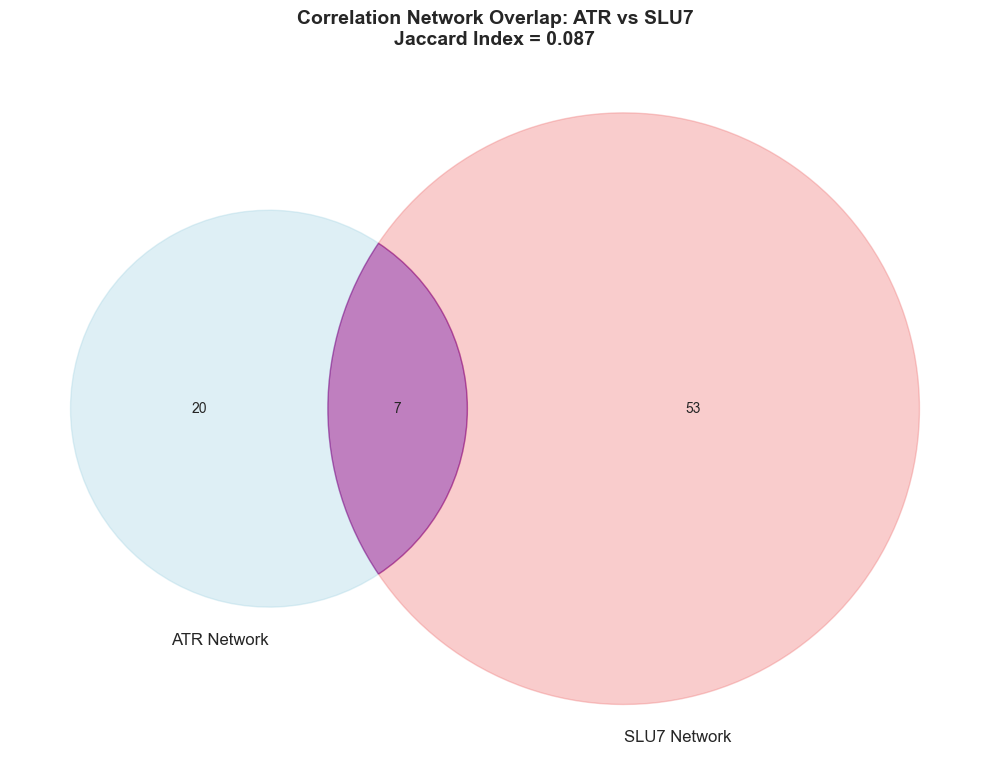


Purple region: 7 shared genes: {'U2SURP', 'FUBP1', 'RPA1', 'DEFB121', 'HIGD1A', 'CHEK1', 'RPA2'}
Blue region: 20 ATR-specific genes
Red region: 53 SLU7-specific genes


In [18]:
def plot_network_venn(network_comparison, gene1_name, gene2_name):
    """
    Visualize network overlap with a Venn diagram.

    Parameters:
    -----------
    network_comparison : dict
        Dictionary returned from compare_correlation_networks()
    gene1_name : str
        Name of first gene
    gene2_name : str
        Name of second gene
    """
    from matplotlib_venn import venn2

    network1 = network_comparison["network1"]
    network2 = network_comparison["network2"]
    jaccard_index = network_comparison["jaccard_index"]
    overlap = network_comparison["overlap"]
    gene1_only = network_comparison["gene1_only"]
    gene2_only = network_comparison["gene2_only"]

    fig, ax = plt.subplots(figsize=(10, 8))

    # Create Venn diagram
    venn = venn2(
        [network1, network2],
        set_labels=(f"{gene1_name} Network", f"{gene2_name} Network"),
        ax=ax,
    )

    # Customize colors
    venn.get_patch_by_id("10").set_color("lightblue")
    venn.get_patch_by_id("01").set_color("lightcoral")
    venn.get_patch_by_id("11").set_color("purple")
    venn.get_patch_by_id("11").set_alpha(0.5)

    ax.set_title(
        f"Correlation Network Overlap: {gene1_name} vs {gene2_name}\nJaccard Index = {jaccard_index:.3f}",
        fontsize=14,
        fontweight="bold",
    )

    plt.tight_layout()
    plt.show()

    print(f"\nPurple region: {len(overlap)} shared genes: {overlap}")
    print(f"Blue region: {len(gene1_only)} {gene1_name}-specific genes")
    print(f"Red region: {len(gene2_only)} {gene2_name}-specific genes")


print("✓ All helper functions loaded successfully!")

# Visualize network overlap with Venn diagram
plot_network_venn(network_stats, 'ATR', 'SLU7')

### 🔍 Biological Interpretation

**What does network overlap mean?**

1. **High overlap (Jaccard > 0.3):** 
   - ATR and SLU7 likely work in the same pathway or complex
   - Shared correlated genes represent a functional module
   - Strong evidence for direct functional relationship

2. **Moderate overlap (Jaccard 0.1-0.3):**
   - Some shared dependencies
   - May work in parallel pathways or have indirect relationships
   - Shared genes worth investigating further

3. **Low overlap (Jaccard < 0.1):**
   - Different functional contexts
   - May represent different aspects of cellular biology
   - Correlation might be due to shared regulation rather than direct interaction

**Next steps for validation:**
- Look up known pathways for overlapping genes
- Check if they're in DNA damage response, cell cycle, or RNA processing
- Consider experimental validation (e.g., co-immunoprecipitation, genetic screens)

---

# Summary and Conclusions

## What We Accomplished

In this notebook, we performed a comprehensive end-to-end correlation analysis:

### 1. **Data Preparation**
   - Loaded DepMap dependency data for 94 cell lines (breast + myeloid)
   - Handled missing values through median imputation
   - Explored data distributions and quality

### 2. **Reusable Analysis Functions**
   - Created modular helper functions for correlation workflow:
     - `calculate_gene_correlations()`: Calculate Pearson & Spearman correlations
     - `apply_fdr_correction()`: Apply Benjamini-Hochberg FDR correction
     - `get_top_correlations()`: Extract significant genes
     - `plot_volcano()`: Visualize correlation strength vs significance
     - `plot_top_correlation_scatter()`: Show gene-gene relationships
     - `analyze_gene_correlations()`: Main wrapper function
   - **Benefit:** Can now analyze ANY gene without code duplication!

### 3. **ATR Correlation Analysis**
   - Found genes significantly correlated with ATR
   - Applied rigorous multiple testing correction
   - Identified top correlated gene: SLU7

### 4. **SLU7 Correlation Analysis**
   - Repeated analysis for SLU7 using same functions
   - Found SLU7's correlation network

### 5. **Network Comparison**
   - Quantified overlap between ATR and SLU7 networks
   - Used Jaccard Index to measure similarity
   - Visualized overlap with Venn diagram

---

## Key Statistical Concepts Learned

1. **Pearson vs Spearman Correlation**
   - Pearson: linear relationships, sensitive to outliers
   - Spearman: monotonic relationships, rank-based, robust

2. **Multiple Testing Problem**
   - Testing 17,000 genes → expect ~850 false positives at α=0.05
   - Solution: FDR correction (Benjamini-Hochberg)
   - Dramatically reduces false discoveries

3. **Network Analysis**
   - Jaccard Index quantifies network similarity
   - High overlap suggests functional relationship
   - Can identify gene modules and pathways

---

## Biological Insights

- ATR is essential for DNA damage response
- Genes correlated with ATR likely work in same pathways
- SLU7's correlation with ATR suggests shared functional context
- Network overlap reveals potential protein complexes or pathways

---

## Code Reusability Win! 🎉

**Before refactoring:** Would need 100+ lines of duplicated code for each gene

**After refactoring:** Just 6 lines to analyze any gene:
```python
results, sig_genes, top_gene = analyze_gene_correlations(
    gene_name='YOUR_GENE',
    gene_df=gene_df,
    numeric_cols=numeric_cols,
    plot_results=True
)
```

This demonstrates **DRY principle** (Don't Repeat Yourself) in data science!